In [1]:
# pip install nltk

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import nltk
import warnings
warnings.filterwarnings("ignore")


In [3]:
df=pd.read_excel("aquaman and the lost kingdom trailer.xlsx")

In [4]:
df=df.drop("Unnamed: 0",axis=1)

# 先對comment做一下處理

In [5]:
    
def comment_clean(text):
    text = re.sub(r'\n', ' ', text)  # 将换行符替换为空格
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # 将多个连续空格替换为一个空格
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # 删除除英文字母、数字和空格外的所有字符
    text = re.sub(r'\W', ' ', text)           #不要特殊字母
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # 再次将多个连续空格替换为一个空格    
    return text
    
    
df["comment"]=df["comment"].apply(comment_clean)   

# 情感分析(判斷是positive netural or negative)

In [6]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["comment"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["comment"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["comment"]]
df['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in df["comment"]]
score = df["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df["Sentiment"] = sentiment
df.head(10)





[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,comment,Positive,Negative,Neutral,Compound,Sentiment
0,Thats the guy from The Flash postcredit scene,0.000,0.000,1.000,0.0000,Neutral
1,Theyre definitely keeping Heard outta the trai...,0.130,0.000,0.870,0.4019,Positive
2,224 Literally only 02 seconds of Heard,0.000,0.000,1.000,0.0000,Neutral
3,They snuck Amber in for one second,0.000,0.000,1.000,0.0000,Neutral
4,You can keep amber in as little as 3 frames bu...,0.000,0.104,0.896,-0.4215,Negative
5,I dont want this to be Jasons last time as Aqu...,0.337,0.029,0.634,0.9279,Positive
6,224 POV Youre Depp hiding behind a locked door,0.000,0.239,0.761,-0.2960,Negative
7,Johny Depp Aquamaaannnn,0.000,0.000,1.000,0.0000,Neutral
8,Its going to be interesting to see Aquaman and...,0.197,0.000,0.803,0.4019,Positive
9,229 His Scream is Funny,0.337,0.314,0.349,0.0516,Positive


In [7]:
df=df.drop(['Positive','Negative','Neutral','Compound'],axis=1)

In [8]:
#簡單做完情感分析後

<Axes: xlabel='Sentiment', ylabel='count'>

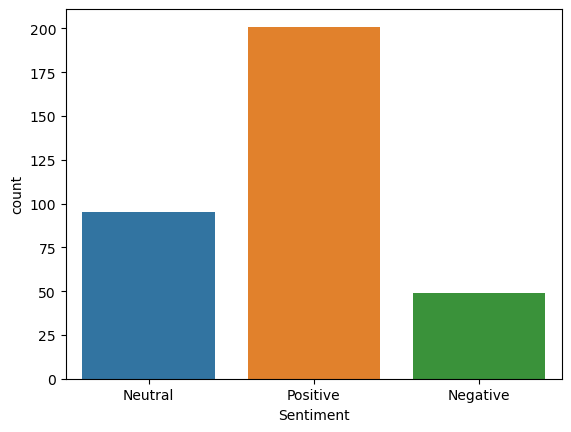

In [9]:
sns.countplot(data=df,x="Sentiment")

In [10]:
df.Sentiment.value_counts()

Positive    201
Neutral      95
Negative     49
Name: Sentiment, dtype: int64

# balance data

In [11]:

df_neutral = df[(df['Sentiment']=="Neutral")] 
df_Negative = df[(df['Sentiment']=="Negative")] 
df_Positive = df[(df['Sentiment']=="Positive")] 

In [12]:
df_negative_upsampled = resample(df_Negative, 
                                 replace=True,    
                                 n_samples= 201, 
                                 random_state=42)  

df_neutral_upsampled = resample(df_neutral, 
                                 replace=True,    
                                 n_samples= 201, 
                                 random_state=42)  

In [13]:
df = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_Positive])

<Axes: xlabel='Sentiment', ylabel='count'>

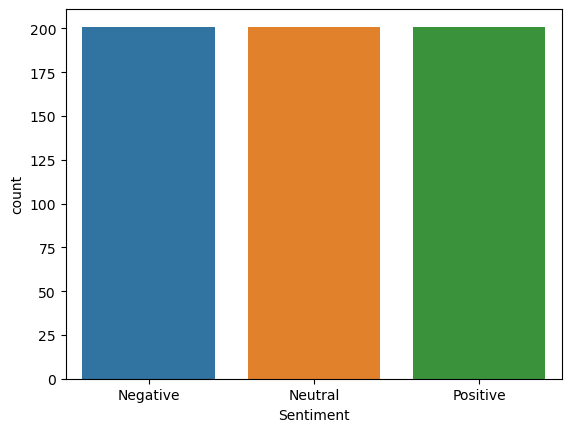

In [14]:
sns.countplot(data=df,x="Sentiment")

In [15]:
X=df["comment"]
y=df["Sentiment"]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf = TfidfVectorizer(stop_words='english')

In [20]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [21]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [22]:
X_train_tfidf

<482x974 sparse matrix of type '<class 'numpy.float64'>'
	with 3624 stored elements in Compressed Sparse Row format>

# 模型選擇- Naive Bayes,LogisticRegression, LinearSVC


In [23]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

In [24]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=1000)
log.fit(X_train_tfidf,y_train)

LogisticRegression(max_iter=1000)

In [25]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_tfidf,y_train)

LinearSVC()

# 模型評估

In [26]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

In [27]:
def report(model):
    preds=model.predict(X_test_tfidf)
    a=classification_report(y_test,preds)
    print(a)
    b=confusion_matrix(y_test,preds)
    c=ConfusionMatrixDisplay(b).plot()
    print(c)

              precision    recall  f1-score   support

    Negative       0.82      0.95      0.88        43
     Neutral       0.90      0.81      0.85        43
    Positive       0.94      0.86      0.90        35

    accuracy                           0.88       121
   macro avg       0.88      0.87      0.88       121
weighted avg       0.88      0.88      0.88       121



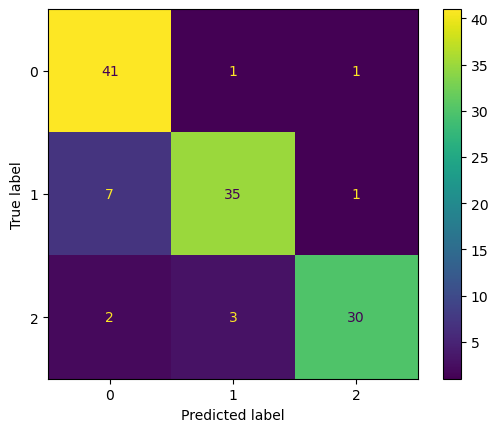

In [28]:
report(nb)

Logistic Regression
              precision    recall  f1-score   support

    Negative       0.85      0.95      0.90        43
     Neutral       0.88      0.84      0.86        43
    Positive       0.94      0.86      0.90        35

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121



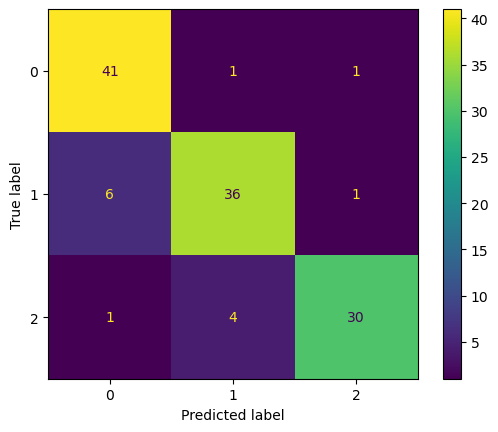

In [29]:
print("Logistic Regression")
report(log)

SVC
              precision    recall  f1-score   support

    Negative       0.91      0.95      0.93        43
     Neutral       0.87      0.91      0.89        43
    Positive       0.97      0.86      0.91        35

    accuracy                           0.91       121
   macro avg       0.92      0.91      0.91       121
weighted avg       0.91      0.91      0.91       121



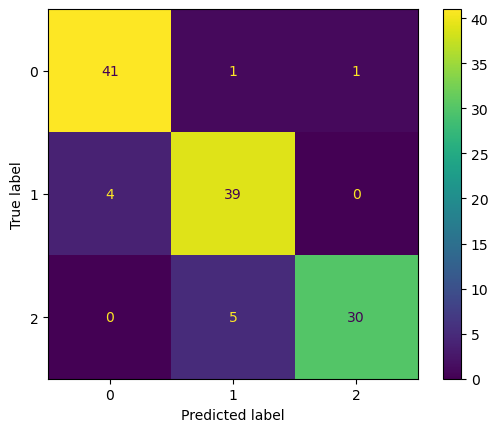

In [30]:
print('SVC')
report(svc)

# 從比較中我們選擇svc，最後使用模型看效果如何


In [31]:
from sklearn.pipeline import Pipeline

In [32]:
pipe = Pipeline([('tfidf',TfidfVectorizer()),('svc',LinearSVC())])           

In [33]:
pipe.fit(df['comment'],df['Sentiment'])


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [34]:

good_comment = ['it will be great can not wait to see it !']
pipe.predict(good_comment)




array(['Positive'], dtype=object)

In [35]:
bad_comment=["bad movie"]
pipe.predict(bad_comment)

array(['Negative'], dtype=object)

In [36]:
Neutral_comment=["zz"]
pipe.predict(Neutral_comment)   

array(['Neutral'], dtype=object)